This kind of messy notebook is first try of epic ml data : The survivors of Titanic

In [2]:
%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn as sns
#sns.set(style="nogrid")
url = "https://raw.github.com/mattdelhey/kaggle-titanic/master/Data/train.csv"
titanic = pd.read_csv(url)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
survived    891 non-null int64
pclass      891 non-null int64
name        891 non-null object
sex         891 non-null object
age         714 non-null float64
sibsp       891 non-null int64
parch       891 non-null int64
ticket      891 non-null object
fare        891 non-null float64
cabin       204 non-null object
embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


In [17]:
titanic_train = titanic.copy()
titanic_target = titanic_train.survived.values
titanic_train = titanic_train.drop(['survived','cabin'],axis=1)
titanic_train['class'] = titanic_train.pclass.map({1:'first',2:'second',3:'third'})
titanic_train = titanic_train.drop(['pclass'],axis=1)
titanic_train['alone'] = ~((titanic_train.sibsp + titanic_train.parch)).astype(bool)

In [18]:
def men_women_child(passenger):
    sex, age = passenger
    if age < 16:
        return 'child'
    else: return 'man' if sex=='male' else 'woman'
titanic_train['who'] = titanic[['sex','age']].apply(men_women_child,axis=1)
age_mean = titanic_train.groupby(['who']).age.mean().to_dict()
titanic_train.loc[titanic_train.age.isnull(),'age'] = titanic_train.loc[titanic_train.age.isnull(),['age','who']].apply(lambda x: age_mean[x['who']],axis=1)

In [19]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    print (big_string)
    return np.nan
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']
titanic_train['title']=titanic_train['name'].map(lambda x: substrings_in_string(x, title_list))
def replace_titles(x):
    title=x['title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
titanic_train['title']=titanic_train.apply(replace_titles, axis=1)

In [24]:
titanic_train = titanic_train.drop(['name','sibsp','parch','ticket','who'],axis=1)
titanic_train.head()

ValueError: labels ['name' 'sibsp' 'parch' 'ticket' 'who'] not contained in axis

In [25]:
titanic_train.describe()

,age,fare
count,891.000000,891.000000
mean,30.319458,32.204208
std,13.063839,49.693429
min,0.420000,0.000000
25%,22.000000,7.910400
50%,32.000000,14.454200
75%,35.000000,31.000000
max,80.000000,512.329200


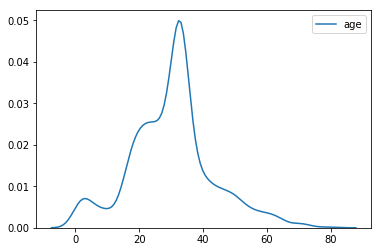

In [32]:
sns.kdeplot(titanic_train.age)

In [94]:
class_dummy = pd.get_dummies(titanic_train['class'],prefix='class')
title_dummy = pd.get_dummies(titanic_train['title'],prefix='title')
embark_dummy = pd.get_dummies(titanic_train['embarked'],prefix='embark')

In [95]:
final = pd.concat([titanic_train,class_dummy,embark_dummy,title_dummy],axis=1)
final['log_fare'] = titanic_train.fare.map(lambda x: np.log(x) if x!=0 else 0) 
final = final.drop(['sex','embarked','class','title','fare'],axis=1)

In [97]:
final.describe()

,age,class_first,class_second,class_third,embark_C,embark_Q,embark_S,title_Master,title_Miss,title_Mr,title_Mrs,log_fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,30.319458,0.242424,0.206510,0.551066,0.188552,0.086420,0.722783,0.044893,0.204265,0.595960,0.154882,2.893846
std,13.063839,0.428790,0.405028,0.497665,0.391372,0.281141,0.447876,0.207186,0.403390,0.490981,0.361996,1.002899
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.068177
50%,32.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.670985
75%,35.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.433987
max,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.238967


In [146]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
sgd = SGDClassifier()
sgd.fit(final,titanic_target)
cross_val_score(sgd,final,titanic_target,cv=3,scoring='accuracy')

/Users/yhhsu/Anaconda/anaconda/envs/ph2t/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 0.62289562,  0.64983165,  0.58922559])

In [147]:
sgd_pred = sgd.predict(final)
(titanic_target==sgd_pred).mean()

0.64870931537598209

In [152]:
tree = DecisionTreeClassifier()
tree.fit(final,titanic_target)
cross_val_score(tree,final,titanic_target,cv=3,scoring='accuracy')

array([ 0.76094276,  0.77104377,  0.77777778])

In [151]:
final.shape

(891, 15)

In [153]:
tree_pred = tree.predict(final)
(titanic_target==tree_pred).mean()

0.98204264870931535

In [154]:
rforest = RandomForestClassifier()
rforest.fit(final,titanic_target)
cross_val_score(rforest,final,titanic_target,cv=3,scoring='accuracy')

array([ 0.78451178,  0.81818182,  0.7979798 ])

In [155]:
rforest_pred = rforest.predict(final)
(titanic_target==rforest_pred).mean()

0.96969696969696972

In [118]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
n = len(final.log_fare)
final['log_fare_rescale'] = scaler.fit_transform(final.log_fare.values.reshape(-1,1))
final['age_rescale'] = scaler.fit_transform(final.age.values.reshape(-1,1))

In [120]:
final_rescale = final.copy()
final_rescale = final_rescale.drop(['log_fare','age_rescale'],axis=1)

In [126]:
rforest = RandomForestClassifier()
rforest.fit(final_rescale,titanic_target)
cross_val_score(rforest,final_rescale,titanic_target,cv=10,scoring='accuracy')

array([ 0.71111111,  0.81111111,  0.71910112,  0.82022472,  0.86516854,
        0.82022472,  0.82022472,  0.78651685,  0.78651685,  0.84090909])

In [124]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
titanic_train_pred = rforest.predict(final_rescale)
print (confusion_matrix(titanic_target,titanic_train_pred))
print (precision_score(titanic_target,titanic_train_pred))
print (recall_score(titanic_target,titanic_train_pred))
print (f1_score(titanic_target,titanic_train_pred))

[[538  11]
 [ 20 322]]
0.966966966967
0.941520467836
0.954074074074


In [127]:
titanic_target.mean()

0.38383838383838381

In [128]:
rforest.fit(final_rescale,titanic_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [132]:
from sklearn.model_selection import GridSearchCV
import time
start = time.time()
rforest2 = RandomForestClassifier()
param_grid = [{
        'n_estimators':[5,10,20], 'max_features':['sqrt','log2',None],
        'min_impurity_decrease':[0,0.5],'class_weight':[None,'balanced']
    }]
grid_search = GridSearchCV(rforest2,param_grid,cv=5,scoring='accuracy')
grid_search.fit(final_rescale,titanic_target)
print (time.time()-start)

3.702467918395996


In [136]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.789001122334 {'class_weight': None, 'max_features': 'sqrt', 'min_impurity_decrease': 0, 'n_estimators': 5}
0.795735129068 {'class_weight': None, 'max_features': 'sqrt', 'min_impurity_decrease': 0, 'n_estimators': 10}
0.812570145903 {'class_weight': None, 'max_features': 'sqrt', 'min_impurity_decrease': 0, 'n_estimators': 20}
0.616161616162 {'class_weight': None, 'max_features': 'sqrt', 'min_impurity_decrease': 0.5, 'n_estimators': 5}
0.616161616162 {'class_weight': None, 'max_features': 'sqrt', 'min_impurity_decrease': 0.5, 'n_estimators': 10}
0.616161616162 {'class_weight': None, 'max_features': 'sqrt', 'min_impurity_decrease': 0.5, 'n_estimators': 20}
0.791245791246 {'class_weight': None, 'max_features': 'log2', 'min_impurity_decrease': 0, 'n_estimators': 5}
0.800224466891 {'class_weight': None, 'max_features': 'log2', 'min_impurity_decrease': 0, 'n_estimators': 10}
0.804713804714 {'class_weight': None, 'max_features': 'log2', 'min_impurity_decrease': 0, 'n_estimators': 20}
0.61616

In [137]:
feature_importances = grid_search.best_estimator_.feature_importances_
attributes = final_rescale.columns
sorted(zip(feature_importances, attributes), reverse=True)

[(0.29675133144458121, 'log_fare_rescale'),
 (0.23920901557845209, 'age'),
 (0.21002181436663186, 'title_Mr'),
 (0.049262802815155764, 'class_third'),
 (0.046249733822021397, 'title_Mrs'),
 (0.040877355218556226, 'title_Miss'),
 (0.028268959660315472, 'class_first'),
 (0.023788289951513598, 'class_second'),
 (0.021038157448809582, 'alone'),
 (0.013823373768217512, 'embark_S'),
 (0.011754363918732441, 'embark_C'),
 (0.010841346706903251, 'embark_Q'),
 (0.0081134553001095989, 'title_Master')]

In [156]:
train_pred = grid_search.best_estimator_.predict(final_rescale)
(train_pred==titanic_target).mean()

0.97643097643097643

In [158]:
def data_transform(titanic):
    titanic_train = titanic.copy()
    titanic_target = titanic_train.survived.values
    titanic_train = titanic_train.drop(['survived','cabin'],axis=1)
    titanic_train['class'] = titanic_train.pclass.map({1:'first',2:'second',3:'third'})
    titanic_train = titanic_train.drop(['pclass'],axis=1)
    titanic_train['alone'] = ~((titanic_train.sibsp + titanic_train.parch)).astype(bool)
    def men_women_child(passenger):
        sex, age = passenger
        if age < 16:
            return 'child'
        else: return 'man' if sex=='male' else 'woman'
    titanic_train['who'] = titanic[['sex','age']].apply(men_women_child,axis=1)
    age_mean = titanic_train.groupby(['who']).age.mean().to_dict()
    titanic_train.loc[titanic_train.age.isnull(),'age'] = titanic_train.loc[titanic_train.age.isnull(),['age','who']].apply(lambda x: age_mean[x['who']],axis=1)
    def substrings_in_string(big_string, substrings):
        for substring in substrings:
            if str.find(big_string, substring) != -1:
                return substring
        return np.nan
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                        'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                        'Don', 'Jonkheer']
    titanic_train['title']=titanic_train['name'].map(lambda x: substrings_in_string(x, title_list))
    def replace_titles(x):
        title=x['title']
        if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Countess', 'Mme']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms']:
            return 'Miss'
        elif title =='Dr':
            if x['sex']=='Male':
                return 'Mr'
            else:
                return 'Mrs'
        else:
            return 'Other'
    titanic_train['title']=titanic_train.apply(replace_titles, axis=1)
    titanic_train = titanic_train.drop(['name','sibsp','parch','ticket','who'],axis=1)
    class_dummy = pd.get_dummies(titanic_train['class'],prefix='class')
    title_dummy = pd.get_dummies(titanic_train['title'],prefix='title')
    embark_dummy = pd.get_dummies(titanic_train['embarked'],prefix='embark')
    final = pd.concat([titanic_train,class_dummy,embark_dummy,title_dummy],axis=1)
    final['log_fare'] = titanic_train.fare.map(lambda x: np.log(x) if x!=0 else 0) 
    final = final.drop(['sex','embarked','class','title','fare'],axis=1)
    final['log_fare_rescale'] = scaler.fit_transform(final.log_fare.values.reshape(-1,1))
    final['age_rescale'] = scaler.fit_transform(final.age.values.reshape(-1,1))
    final = final.drop(['log_fare','age_rescale'],axis=1)
    return final

In [162]:
test_train = data_transform(titanic)
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(test_train,titanic_target,test_size=0.2)

In [167]:
tree = DecisionTreeClassifier()
tree.fit(x_train,y_train)
y_pred = tree.predict(x_test)
(y_pred==y_test).mean()

0.68156424581005581

In [168]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
(y_pred==y_test).mean()

0.72625698324022347

In [169]:
start = time.time()
rf2 = RandomForestClassifier()
param_grid = [{
        'n_estimators':[5,10,20,30], 'max_features':['sqrt','log2',None],
        'class_weight':[None,'balanced']
    }]
grid_search = GridSearchCV(rf2,param_grid,cv=10,scoring='accuracy')
grid_search.fit(x_train,y_train)
print (time.time()-start)
y_pred = grid_search.best_estimator_.predict(x_test)
(y_test==y_pred).mean()

7.050845146179199


0.71508379888268159

In [171]:
feature_importances = grid_search.best_estimator_.feature_importances_
attributes = test_train.columns
sorted(zip(feature_importances, attributes), reverse=True)

[(0.41716137554019139, 'age'),
 (0.37481803647224216, 'log_fare_rescale'),
 (0.069484204733780308, 'class_third'),
 (0.041363429256770702, 'alone'),
 (0.023570450785082842, 'embark_C'),
 (0.020791669972592332, 'class_first'),
 (0.014227523564127565, 'embark_S'),
 (0.013597553909952745, 'class_second'),
 (0.0085708430859418854, 'embark_Q'),
 (0.007111581013607979, 'title_Mr'),
 (0.0067375302950997374, 'title_Other'),
 (0.0024051565571639897, 'title_Mrs'),
 (0.00016064481344633098, 'title_Miss')]

In [170]:
cross_val_score(rf2,x_train,y_train,cv=10,scoring='accuracy')

array([ 0.68493151,  0.67605634,  0.69014085,  0.71830986,  0.67605634,
        0.70422535,  0.67605634,  0.70422535,  0.6056338 ,  0.74647887])